# No control

Compare peak calling results without / with peaks

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import pandas as pd
import seaborn as sns
from IPython.display import display
from tqdm.auto import tqdm

sns.set_style("whitegrid")
import matplotlib.pyplot as plt
import numpy as np
import os
import re
from itertools import product
import tempfile

In [2]:
def bedl(file):
    try:
        tf = pd.read_csv(file, sep='\t', header=None)
        return tf[2] - tf[1]
    except:
        return np.zeros(0)  # Empty file


def lines(file):
    try:
        tf = pd.read_csv(file, sep='\t', header=None)
        return len(tf)
    except:
        return 0  # Empty file


def d(a, b):
    return a / b if b != 0 else 0


def last_col(file):
    try:
        cols = len(pd.read_csv(file, sep='\t', nrows=1, header=None).columns)
        return pd.read_csv(file, sep='\t', header=None, usecols=[cols - 1])[cols - 1]
    except:
        return np.zeros(0)  # Empty file


def sorted_file(file):
    ts = tempfile.mktemp()
    ! cat {file} | sort -k1,1 -k2,2n -k3,3n > {ts}
    return ts

# Load hg38 peaks

1. Create dataset without control tracks
2. Launch peak calling

```
conda activate snakemake
snakemake -p -s ~/work/chipseq-smk-pipeline/Snakefile all --cores all  --use-conda  --directory $(pwd) --config genome=hg38 fastq_dir=$(pwd) start_with_bams=True bams_dir=bams macs2=True span=False sicer=False --rerun-trigger mtime;
snakemake -p -s ~/work/chipseq-smk-pipeline/Snakefile all --cores all  --use-conda  --directory $(pwd) --config genome=hg38 fastq_dir=$(pwd) start_with_bams=True bams_dir=bams macs2=True macs2_mode=broad macs2_params="--broad --broad-cutoff=0.1" macs2_suffix="broad0.1"  span=False sicer=False --rerun-trigger mtime; 
snakemake -p -s ~/work/chipseq-smk-pipeline/Snakefile all --cores all  --use-conda  --directory $(pwd) --config genome=hg38 fastq_dir=$(pwd) start_with_bams=True bams_dir=bams macs2=False span=True sicer=True --rerun-trigger mtime;
```


In [3]:
GSE26320_PATH = os.path.expanduser('~/data/2023_GSE26320')
GSE26320_NO_CONTROL_PATH = os.path.expanduser('~/data/2023_GSE26320_no_control')
GSE26320_CELLS = ['GM12878', 'HMEC', 'HSMM', 'K562', 'NHEK', 'NHLF', 'H1', 'Huvec', 'HepG2']
MODIFICATIONS = ['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3']
GSE26320_REPS = ['rep1', 'rep2']

IMMUNE_PATH = os.path.expanduser('~/data/2023_Immune')
IMMUNE_NO_CONTROL_PATH = os.path.expanduser('~/data/2023_Immune_no_control')
IMMUNE_CELLS = ['CD4ABT', 'TCellBB', 'BCell', 'TCell', 'Monocyte', 'PBMC', 'NK', 'CD34', 'CD4', ]  ## Longest first
IMMUNE_REPS = ['rep1', 'rep2', 'rep3', '']

! mkdir -p {GSE26320_PATH}/pics
! mkdir -p {IMMUNE_PATH}/pics

In [4]:
TOOLS = ['MACS2', 'MACS2 broad', 'SPAN', 'SICER']
palette = plt.cm.get_cmap('tab10')
TOOLS_PALETTE = {t: palette(i) for i, t in enumerate(TOOLS)}

In [5]:
def load_peaks(path, suffix, modifications, cells, replicates):
    df = pd.DataFrame(columns=['file', 'modification', 'cell', 'replicate', 'peaks'],
                      dtype=object)
    for f in tqdm(os.listdir(path)):
        if not f.endswith(suffix):
            continue
        cell = next((c for c in cells if c in f), None)
        mod = next((m for m in modifications if m in f), None)
        rep = next((r for r in replicates if r in f), None)
        if cell and mod and rep is not None:
            peaks_path = os.path.join(path, f)
            ps = lines(peaks_path)
            df.loc[len(df)] = (peaks_path, mod, cell, rep, ps)
    return df

In [6]:
def load_peaks_path(path, modifications, cells, replicates):
    df_macs2 = load_peaks(os.path.join(path, 'macs2'), '.narrowPeak', modifications, cells, replicates)
    df_macs2['tool'] = 'MACS2'
    print('MACS2', len(df_macs2))

    df_macs2broad = load_peaks(os.path.join(path, 'macs2'), '.broadPeak', modifications, cells, replicates)
    df_macs2broad['tool'] = 'MACS2 broad'
    print('MACS2 broad', len(df_macs2broad))

    df_sicer = load_peaks(os.path.join(path, 'sicer'), 'summary-FDR0.01', modifications, cells, replicates)
    if len(df_sicer) == 0:
        df_sicer = load_peaks(os.path.join(path, 'sicer'), '.scoreisland', modifications, cells, replicates) 
    df_sicer['tool'] = 'SICER'
    print('SICER', len(df_sicer))

    df_span = load_peaks(os.path.join(path, 'span'), '.peak', modifications, cells, replicates)
    # t = df_span[['_200_' in f for f in df_span['file']]]
    # if len(t) != 0:
    #     df_span = t  # Fallback to 100bp
    df_span['tool'] = 'SPAN'
    print('SPAN', len(df_span))

    return pd.concat([df_macs2, df_macs2broad, df_sicer, df_span]).reset_index(drop=True)

In [7]:
df_encode_peaks = load_peaks_path(GSE26320_PATH, MODIFICATIONS, GSE26320_CELLS, GSE26320_REPS)
df_encode_peaks['dataset'] = 'ENCODE'
df_encode_peaks['control'] = True
df_encode_no_control_peaks = load_peaks_path(GSE26320_NO_CONTROL_PATH, MODIFICATIONS, GSE26320_CELLS, GSE26320_REPS)
df_encode_no_control_peaks['dataset'] = 'ENCODE'
df_encode_no_control_peaks['control'] = False
df_immune_peaks = load_peaks_path(IMMUNE_PATH, MODIFICATIONS, IMMUNE_CELLS, IMMUNE_REPS)
df_immune_peaks['dataset'] = 'Roadmap'
df_immune_peaks['control'] = True
df_immune_no_control_peaks = load_peaks_path(IMMUNE_NO_CONTROL_PATH, MODIFICATIONS, IMMUNE_CELLS, IMMUNE_REPS)
df_immune_no_control_peaks['dataset'] = 'Roadmap'
df_immune_no_control_peaks['control'] = False
df_peaks = pd.concat([df_encode_peaks, df_encode_no_control_peaks, 
                      df_immune_peaks, df_immune_no_control_peaks]).reset_index(drop=True)
df_peaks.sample(3)

  0%|          | 0/680 [00:00<?, ?it/s]

MACS2 85


  0%|          | 0/680 [00:00<?, ?it/s]

MACS2 broad 85


  0%|          | 0/85 [00:00<?, ?it/s]

SICER 85


  0%|          | 0/85 [00:00<?, ?it/s]

SPAN 85


  0%|          | 0/680 [00:00<?, ?it/s]

MACS2 85


  0%|          | 0/680 [00:00<?, ?it/s]

MACS2 broad 85


  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

SICER 85


  0%|          | 0/88 [00:00<?, ?it/s]

SPAN 85


  0%|          | 0/368 [00:00<?, ?it/s]

MACS2 46


  0%|          | 0/368 [00:00<?, ?it/s]

MACS2 broad 46


  0%|          | 0/47 [00:00<?, ?it/s]

SICER 46


  0%|          | 0/46 [00:00<?, ?it/s]

SPAN 46


  0%|          | 0/368 [00:00<?, ?it/s]

MACS2 46


  0%|          | 0/368 [00:00<?, ?it/s]

MACS2 broad 46


  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

SICER 46


  0%|          | 0/49 [00:00<?, ?it/s]

SPAN 46


,file,modification,cell,replicate,peaks,tool,dataset,control
434,/home/jetbrains/data/2023_GSE26320_no_control/...,H3K27ac,K562,rep1,51033,MACS2 broad,ENCODE,False
482,/home/jetbrains/data/2023_GSE26320_no_control/...,H3K4me1,NHLF,rep2,66543,MACS2 broad,ENCODE,False
1033,/home/jetbrains/data/2023_Immune_no_control/sp...,H3K4me1,BCell,,80627,SPAN,Roadmap,False


In [8]:
# Remove outliers, see 2023 - figures.ipynb
# OUTLIERS = [('H3K4me3', 'NK', ''),
#             ('H3K4me1', 'NK', ''),
#             ('H3K27me3', 'TCell', ''),
#             ('H3K27me3', 'H1', 'rep1'),
#             ('H3K27me3', 'HMEC', 'rep2'),
#             ('H3K27me3', 'NHLF', 'rep2'),
#             ('H3K27me3', 'HepG2', 'rep1'),
#             ('H3K27me3', 'GM12878', 'rep1')]
OUTLIERS = [('H3K4me3', 'NK', ''),
           ('H3K4me1', 'NK', ''),
           ('H3K27me3', 'TCell', ''),
           ('H3K27me3', 'NHLF', 'rep2'),
           ('H3K27me3', 'GM12878', 'rep1')]

df_peaks = df_peaks.loc[[(m, c, r) not in OUTLIERS
                         for _, (m, c, r) in df_peaks[['modification', 'cell', 'replicate']].iterrows()]]

ENCODE


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette usin

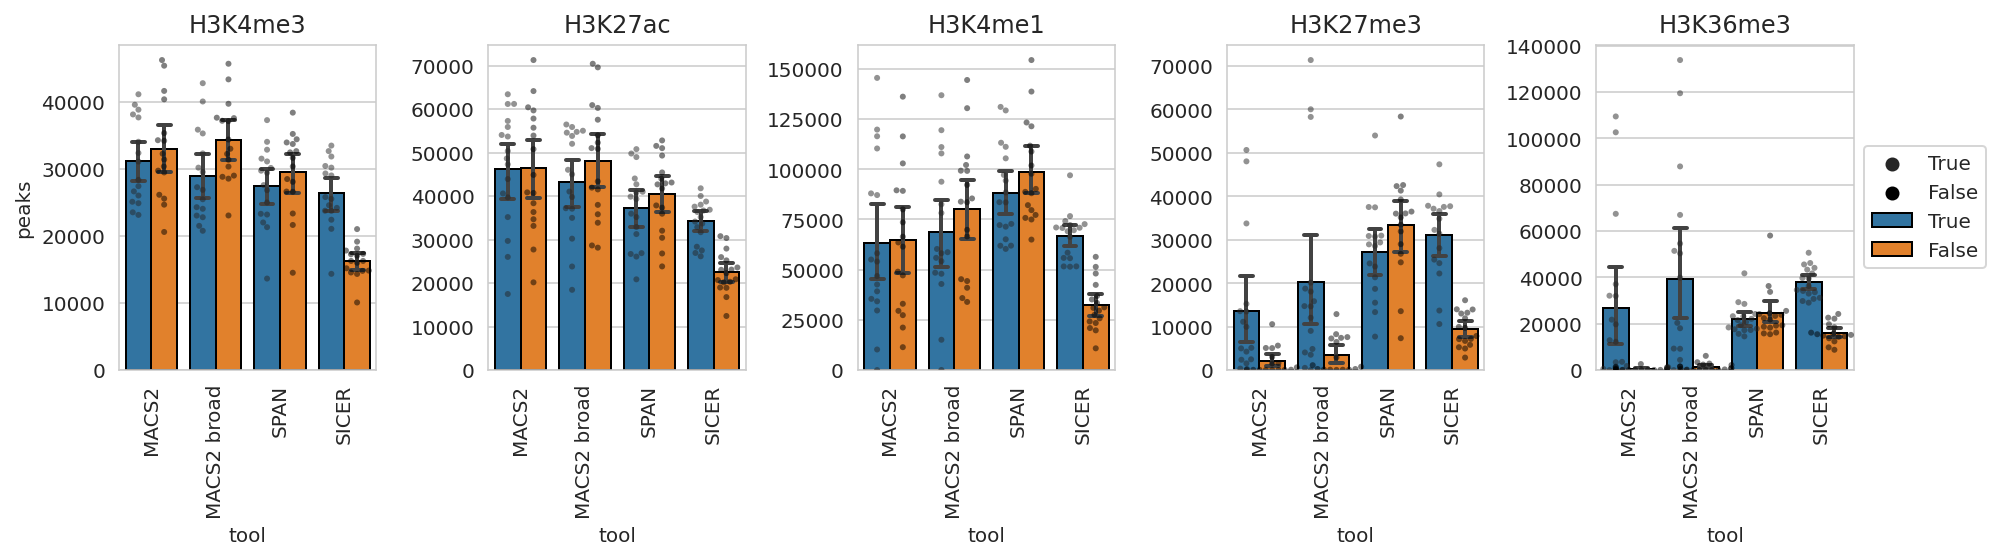

Roadmap


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette usin

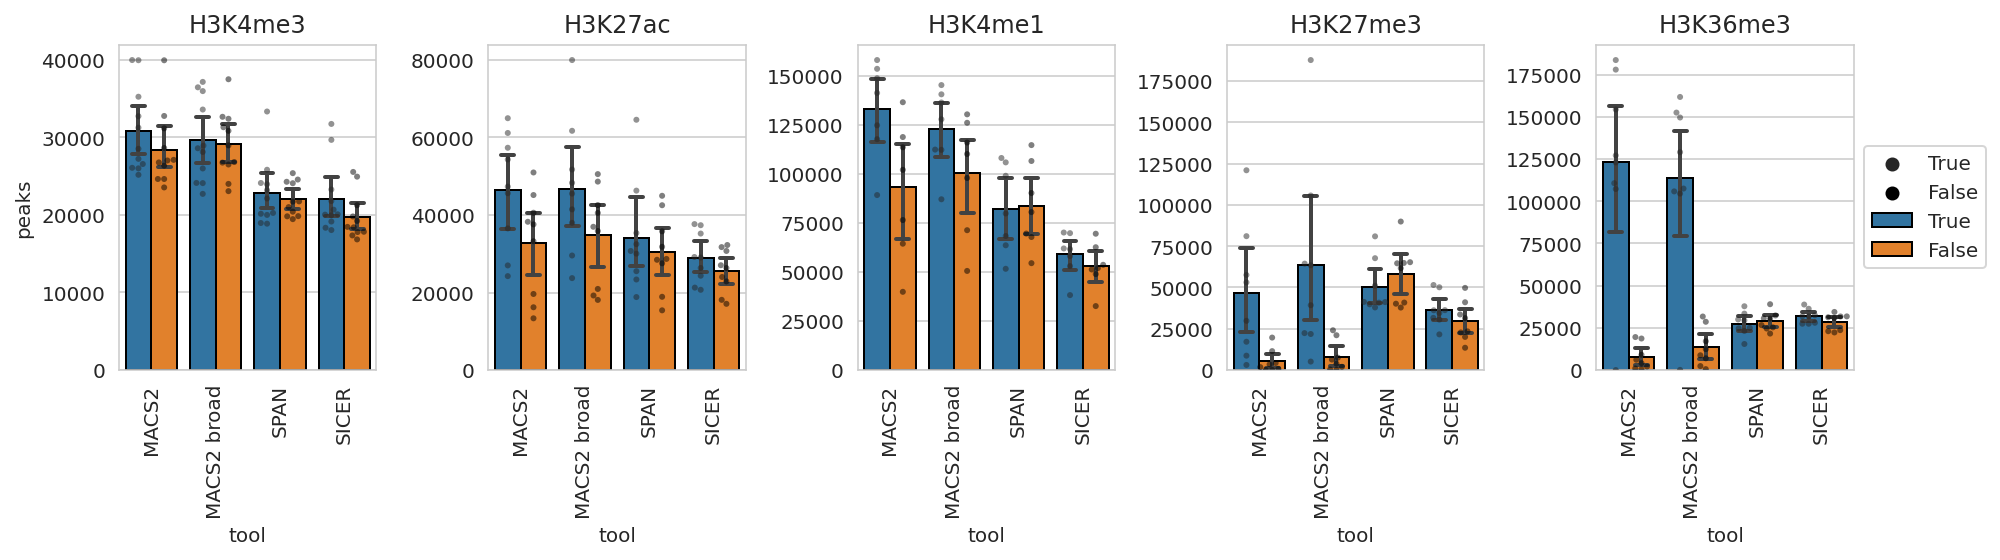

In [9]:
for ds in ['ENCODE', 'Roadmap']:
    print(ds)
    plt.figure(figsize=(14, 4))
    axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
    for i, m in enumerate(MODIFICATIONS):
        ax = axs[i]
        sns.barplot(data=df_peaks[(df_peaks['dataset'] == ds) & 
                                  (df_peaks['modification'] == m)], x='tool', y='peaks', hue='control',
                    capsize=.2, errwidth=2, edgecolor="black",
                    order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                    hue_order=[True, False],
                    ax=ax,)
        sns.swarmplot(data=df_peaks[(df_peaks['dataset'] == ds) &
                                    (df_peaks['modification'] == m)], x='tool', y='peaks', hue='control',
                      dodge=True, size=3, color="black", alpha=0.5,
                      order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                      hue_order=[True, False],
                      ax=ax)

        ax.xaxis.set_tick_params(rotation=90)
        ax.title.set_text(m)
        if i > 0:
            ax.set_ylabel(None)
        else:
            ax.set_ylabel('peaks')
        if i < 4:
            ax.legend().set_visible(False)
        else:
            # Put a legend to the right of the current axis
            ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

        # ax.set_ylim(0, 1.9e7)
    plt.tight_layout()
    # plt.savefig(GSE26320_PATH_HG38 + f'/pics/library_mapped_detailed_all.pdf', bbox_inches='tight', dpi=300)
    plt.show()

# Compute ratio no control vs control

In [10]:
rows = []
for (ds, m, c, r, t), dft in tqdm(df_peaks.groupby(['dataset', 'modification', 'cell', 'replicate', 'tool'])):
    if len(dft) == 2:
        with_control = dft[dft['control'] == True]['file'].values[0]
        without_control = dft[dft['control'] == False]['file'].values[0]
        peaks_with_control = lines(with_control)
        peaks_without_control = lines(without_control)
        rows.append((ds, m, c, r, t, d(peaks_without_control, peaks_with_control)))
df_ratio = pd.DataFrame(rows, columns=['dataset', 'modification', 'cell', 'replicate', 'tool', 'ratio'])
df_ratio['ratio'] = ((df_ratio['ratio'] - 1) * 100).astype(int)
del rows
df_ratio.sample(3)

  0%|          | 0/504 [00:00<?, ?it/s]

,dataset,modification,cell,replicate,tool,ratio
107,ENCODE,H3K27me3,Huvec,rep1,SPAN,14
272,ENCODE,H3K4me3,GM12878,rep2,MACS2,-20
206,ENCODE,H3K4me1,GM12878,rep2,SICER,-59


ENCODE


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


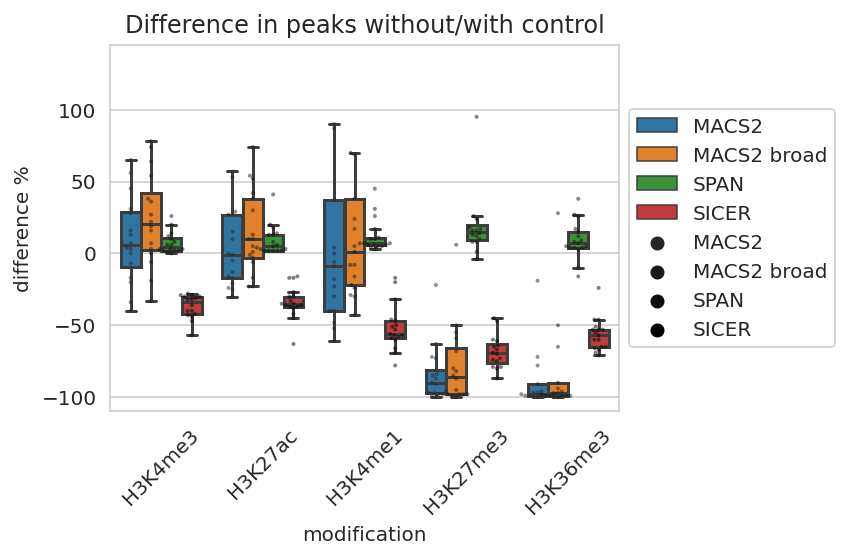

Roadmap


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


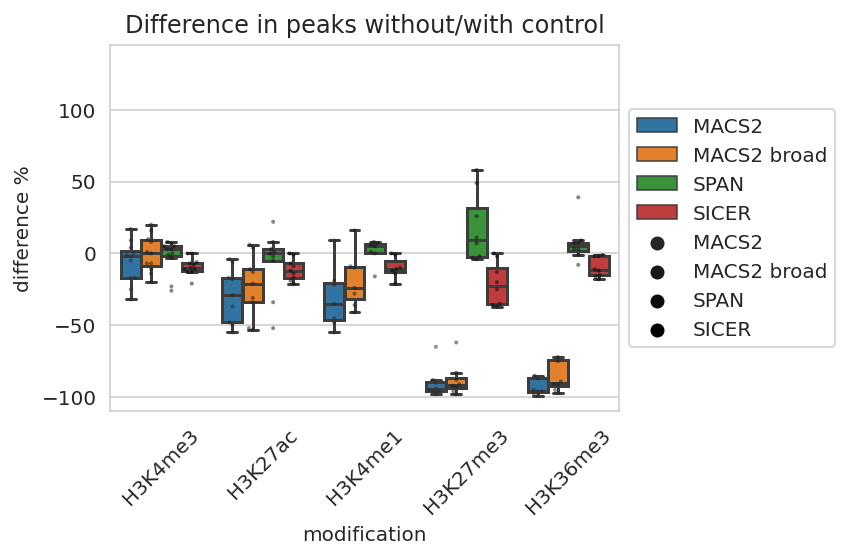

In [29]:
for ds in ['ENCODE', 'Roadmap']:
    print(ds)
    plt.figure(figsize=(6, 4))
    ax = plt.axes()
    sns.boxplot(data=df_ratio[df_ratio['dataset'] == ds],
                x='modification', y='ratio', hue='tool',
                showfliers=False,
                order=['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3'],
                hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                ax=ax)
    sns.swarmplot(data=df_ratio[df_ratio['dataset'] == ds],
                  x='modification', y='ratio', hue='tool',
                  dodge=True, size=2, color="black", alpha=0.5,
                  order=['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3'],
                  hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                  ax=ax)    
    ax.set_ylabel('difference %')
    ax.xaxis.set_tick_params(rotation=45)
    ax.set_ylim(-110, 145)
    ax.set_title('Difference in peaks without/with control')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    plt.show()

# Jaccard without control vs with control

In [12]:
tf = tempfile.mktemp()
rows = []
for (ds, m, c, r, t), dft in tqdm(df_peaks.groupby(['dataset', 'modification', 'cell', 'replicate', 'tool'])):
    if len(dft) == 2:
        with_control = sorted_file(dft[dft['control'] == True]['file'].values[0])
        without_control = sorted_file(dft[dft['control'] == False]['file'].values[0])
        peaks_with_control = lines(with_control)
        peaks_without_control = lines(without_control)
        len_with_control = bedl(with_control).sum()
        len_without_control = bedl(without_control).sum()
        !bedtools intersect -a {with_control} -b {without_control} -wo > {tf}
        overlap_len = int(last_col(tf).sum())
        jaccard = d(overlap_len, len_with_control + len_without_control - overlap_len)
        rows.append((ds, m, c, r, t, peaks_with_control, peaks_without_control, len_with_control, len_without_control, 
                     d(len_with_control, peaks_with_control), d(len_without_control, peaks_without_control),
                     overlap_len, jaccard))
df_jaccard = pd.DataFrame(rows, columns=['dataset', 'modification', 'cell', 'replicate', 'tool',
                                         'peaks_with_control', 'peaks_without_control',
                                         'len_with_control', 'len_without_control', 
                                         'avg_len_with_control', 'avg_len_without_control',
                                         'overlap_len', 'jaccard'])
del rows
df_jaccard.sample(3)

  0%|          | 0/504 [00:00<?, ?it/s]

,dataset,modification,cell,replicate,tool,peaks_with_control,peaks_without_control,len_with_control,len_without_control,avg_len_with_control,avg_len_without_control,overlap_len,jaccard
217,ENCODE,H3K4me1,HMEC,rep1,MACS2 broad,15099,106327,7524484.0,63932875,498.343202,601.285421,6802608,0.105214
375,Roadmap,H3K27me3,CD34,,SPAN,39818,37855,269803240.0,295547784,6775.911397,7807.364523,263451156,0.872644
31,ENCODE,H3K27ac,HepG2,rep1,SPAN,26891,30419,71976709.0,85886479,2676.609609,2823.448470,71828906,0.834887


ENCODE


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


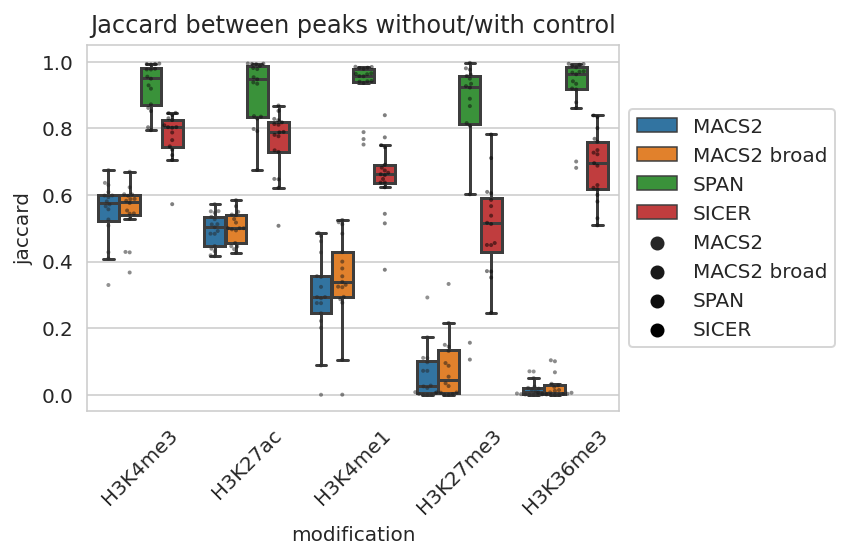

Roadmap


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


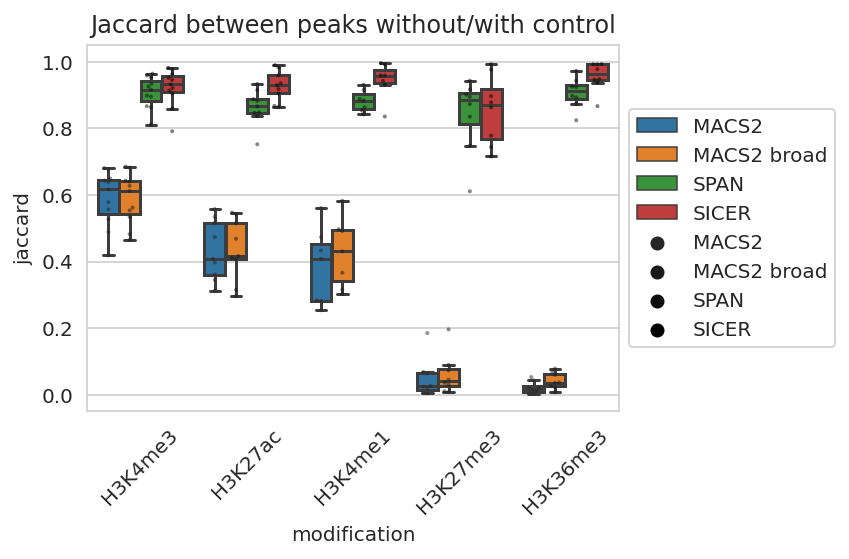

In [30]:
for ds in ['ENCODE', 'Roadmap']:
    print(ds)
    plt.figure(figsize=(6, 4))
    ax = plt.axes()
    sns.boxplot(data=df_jaccard[df_jaccard['dataset'] == ds],
                x='modification', y='jaccard', hue='tool',
                showfliers=False,
                order=['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3'],
                hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                ax=ax)
    sns.swarmplot(data=df_jaccard[df_jaccard['dataset'] == ds],
                  x='modification', y='jaccard', hue='tool',
                  dodge=True, size=2, color="black", alpha=0.5,
                  order=['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3'],
                  hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                  ax=ax)
    ax.set_ylabel('jaccard')
    ax.xaxis.set_tick_params(rotation=45)
    ax.set_ylim(-0.05, 1.05)
    ax.set_title('Jaccard between peaks without/with control')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    plt.show()

In [31]:
df_jaccard[(df_jaccard['dataset'] == 'Roadmap') & 
         (df_jaccard['modification'] == 'H3K27me3') & 
         (df_jaccard['jaccard'] < 0.2)]

,dataset,modification,cell,replicate,tool,peaks_with_control,peaks_without_control,len_with_control,len_without_control,avg_len_with_control,avg_len_without_control,overlap_len,jaccard,union_len,overlap_diff
368,Roadmap,H3K27me3,BCell,,MACS2,120947,11481,62817094.0,4307222,519.377033,375.160874,4064940,0.064462,63059376.0,58994436.0
369,Roadmap,H3K27me3,BCell,,MACS2 broad,187656,21098,115946312.0,8882313,617.866266,421.002607,8526993,0.073318,116301632.0,107774639.0
372,Roadmap,H3K27me3,CD34,,MACS2,53084,1819,29118068.0,594207,548.528144,326.666850,545712,0.018710,29166563.0,28620851.0
373,Roadmap,H3K27me3,CD34,,MACS2 broad,64451,3891,45059059.0,1455076,699.121177,373.959393,1383724,0.030661,45130411.0,43746687.0
376,Roadmap,H3K27me3,CD34,rep2,MACS2,81061,4321,70038383.0,1913425,864.020713,442.819949,1868617,0.026663,70083191.0,68214574.0
377,Roadmap,H3K27me3,CD34,rep2,MACS2 broad,105668,7535,105504627.0,3847627,998.453903,510.633975,3792270,0.035925,105559984.0,101767714.0
380,Roadmap,H3K27me3,CD4,,MACS2,3126,113,1004365.0,43409,321.293986,384.150442,4627,0.004436,1043147.0,1038520.0
381,Roadmap,H3K27me3,CD4,,MACS2 broad,5166,179,2053450.0,71059,397.493225,396.977654,23183,0.011033,2101326.0,2078143.0
384,Roadmap,H3K27me3,CD4,rep2,MACS2,8738,148,3386228.0,60751,387.528954,410.479730,18655,0.005441,3428324.0,3409669.0
385,Roadmap,H3K27me3,CD4,rep2,MACS2 broad,21849,387,9943058.0,155111,455.080690,400.803618,90950,0.009088,10007219.0,9916269.0


In [15]:
df_jaccard['union_len'] = df_jaccard['len_with_control'] + df_jaccard['len_without_control']  - df_jaccard['overlap_len']
df_jaccard['overlap_diff'] = df_jaccard['len_with_control'] + df_jaccard['len_without_control']  - 2 * df_jaccard['overlap_len']

ENCODE


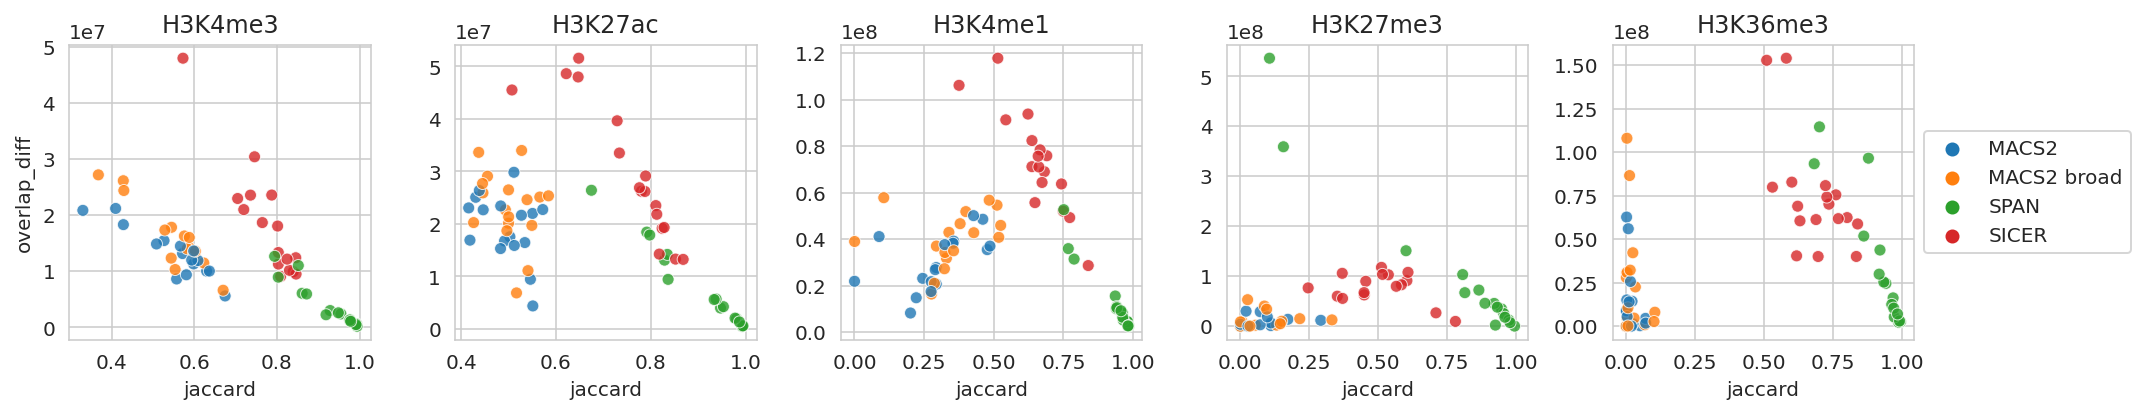

Roadmap


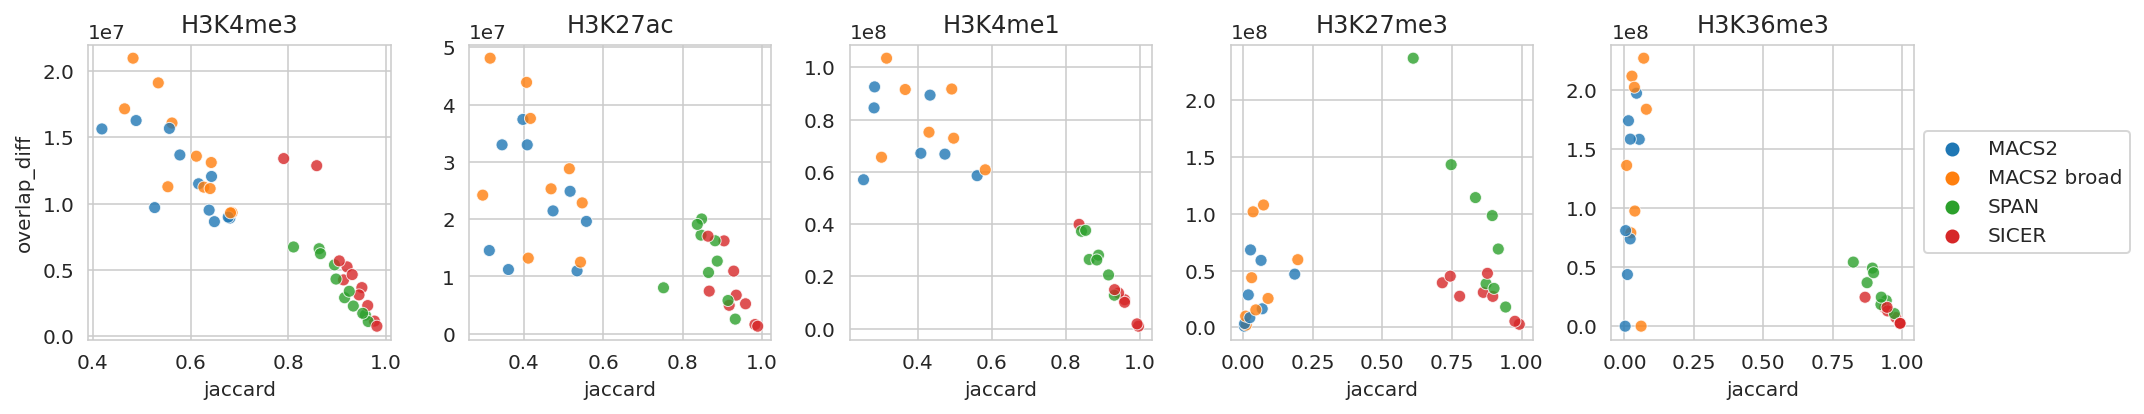

In [16]:
for ds in ['ENCODE', 'Roadmap']:
    print(ds)
    plt.figure(figsize=(15, 3))
    axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
    for i, m in enumerate(MODIFICATIONS):
        ax = axs[i]
        sns.scatterplot(df_jaccard[(df_jaccard['dataset'] == ds) &
                                   (df_jaccard['modification'] == m)],
                        palette=TOOLS_PALETTE,
                        hue_order=TOOLS,
                        x='jaccard', y='overlap_diff', hue='tool', alpha=0.8,
                        ax = ax)
        ax.set_title(m)
        if i > 0:
            ax.set_ylabel(None)
        if i < len(axs) - 1:
            ax.legend().set_visible(False)
        else:
            # Put a legend to the right of the current axis
            ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    plt.show()

In [17]:
rows = []
for _, (ds, modification, tool, jaccard, avlc, avlwc) in df_jaccard[
    ['dataset', 'modification', 'tool', 'jaccard', 'avg_len_with_control', 'avg_len_without_control']].iterrows():
    rows.append((ds, modification, tool, jaccard, avlc))
    rows.append((ds, modification, tool, jaccard, avlwc))
df_jaccard_avg_len = pd.DataFrame(rows, columns=['dataset', 'modification', 'tool', 'jaccard', 'average_len'])
del rows

ENCODE


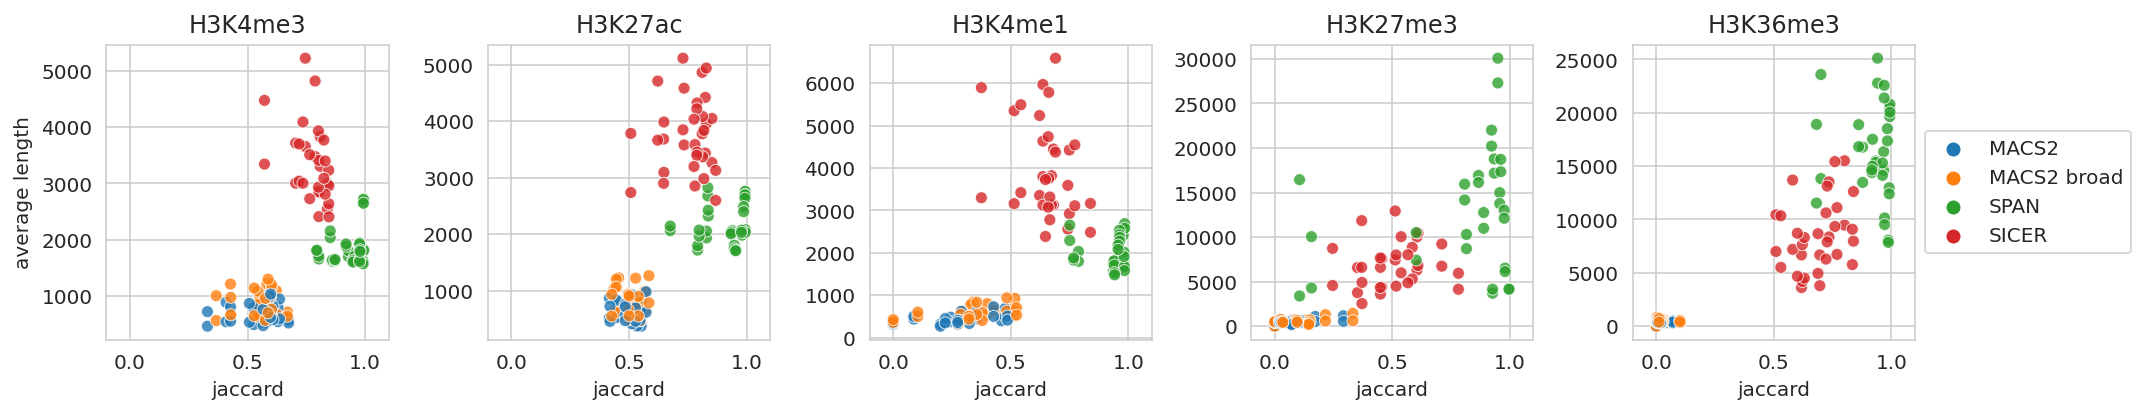

Roadmap


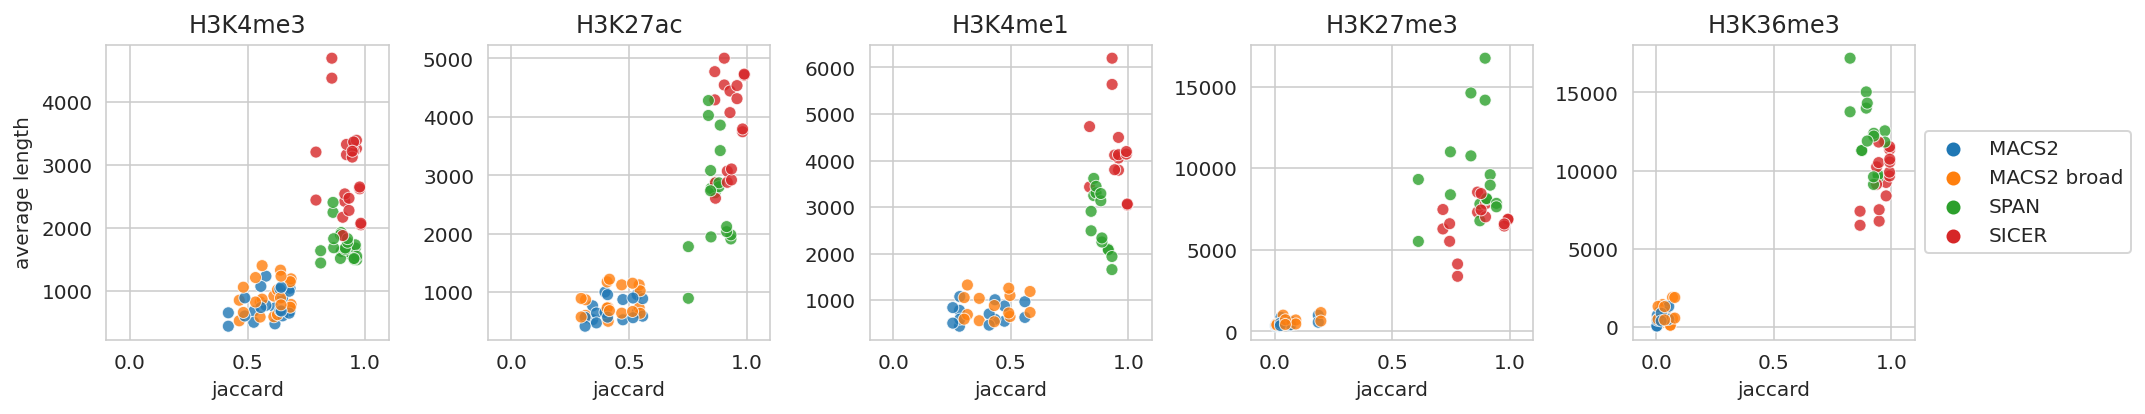

In [18]:
for ds in ['ENCODE', 'Roadmap']:
    print(ds)
    plt.figure(figsize=(15, 3))
    axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
    for i, m in enumerate(MODIFICATIONS):
        ax = axs[i]
        sns.scatterplot(
            df_jaccard_avg_len[(df_jaccard_avg_len['dataset'] == ds) &
                       (df_jaccard_avg_len['modification'] == m)],
            palette=TOOLS_PALETTE,
            hue_order=TOOLS,
            x='jaccard', y='average_len', hue='tool', alpha=0.8,
            ax = ax,
            # fill=True
        )
        ax.set_title(m)
        ax.set_xlim(-0.1, 1.1)
        ax.set_title(m)
        if i > 0:
            ax.set_ylabel(None)
        else:
            ax.set_ylabel('average length')
        if i < len(axs) - 1:
            ax.legend().set_visible(False)
        else:
            # Put a legend to the right of the current axis
            ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    plt.show()

In [19]:
# K27me3 outliers HepG2 rep1 and HMEC rep2
df_jaccard[(df_jaccard['dataset'] == 'ENCODE') & (df_jaccard['modification'] == 'H3K27me3') & (df_jaccard['tool']=='SPAN')]

,dataset,modification,cell,replicate,tool,peaks_with_control,peaks_without_control,len_with_control,len_without_control,avg_len_with_control,avg_len_without_control,overlap_len,jaccard,union_len,overlap_diff
71,ENCODE,H3K27me3,GM12878,rep2,SPAN,21369,24811,642764451.0,677327897,30079.294820,27299.500101,642764301,0.948970,677328047.0,34563746.0
75,ENCODE,H3K27me3,H1,rep1,SPAN,7709,7344,28551394.0,30491881,3703.644312,4151.944581,28396259,0.926559,30647016.0,2250757.0
79,ENCODE,H3K27me3,H1,rep2,SPAN,13353,13566,56156586.0,56325887,4205.540777,4151.989312,56137494,0.996318,56344979.0,207485.0
83,ENCODE,H3K27me3,HMEC,rep1,SPAN,37477,42603,561587037.0,586501043,14984.845025,13766.660634,561418133,0.956957,586669947.0,25251814.0
87,ENCODE,H3K27me3,HMEC,rep2,SPAN,15523,42359,66602944.0,425836883,4290.597436,10053.043816,66592621,0.156377,425847206.0,359254585.0
91,ENCODE,H3K27me3,HSMM,rep1,SPAN,28948,36027,461666065.0,510340318,15948.116105,14165.495823,434307172,0.807714,537699211.0,103392039.0
95,ENCODE,H3K27me3,HSMM,rep2,SPAN,37548,41319,488880872.0,500583596,13020.157452,12115.094654,488712853,0.975959,500751615.0,12038762.0
99,ENCODE,H3K27me3,HepG2,rep1,SPAN,18708,36494,63500509.0,600018917,3394.297039,16441.577163,63499906,0.105830,600019520.0,536519614.0
103,ENCODE,H3K27me3,HepG2,rep2,SPAN,24559,28991,540437196.0,585929846,22005.667820,20210.749750,540373590,0.922150,585993452.0,45619862.0
107,ENCODE,H3K27me3,Huvec,rep1,SPAN,30740,35152,392295491.0,386264144,12761.727098,10988.397360,366324962,0.888632,412234673.0,45909711.0


In [20]:
# for ds, m in product(['ENCODE', 'Roadmap'], ['H3K4me3', 'H3K36me3']):
#     print(ds, m)
#     plt.figure(figsize=(5, 3))
#     ax = plt.axes()
#     # sns.kdeplot(
#         
#     sns.scatterplot(
#         df_jaccard[(df_jaccard['dataset'] == ds) &
#                                (df_jaccard['modification'] == m)],
#                     palette=TOOLS_PALETTE,
#                     hue_order=TOOLS,
#                     x='jaccard', y='avg_len_with_control', hue='tool', alpha=0.8,
#                     ax = ax,
#     # fill=True
#     )
#     ax.set_title(m)
#     ax.set_xlim(-0.1, 1.1)
#     ax.set_ylabel('average length')
#     # Put a legend to the right of the current axis
#     ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#     plt.tight_layout()
#     plt.show()

In [21]:
# for ds, m in product(['ENCODE', 'Roadmap'], ['H3K4me3', 'H3K36me3']):
#     print(ds, m)
#     plt.figure(figsize=(5, 3))
#     ax = plt.axes()
#     sns.scatterplot(df_jaccard[(df_jaccard['dataset'] == ds) &
#                                (df_jaccard['modification'] == m)],
#                     palette=TOOLS_PALETTE,
#                     hue_order=TOOLS,
#                     x='avg_len_with_control', y='avg_len_without_control', hue='tool', alpha=0.8,
#                     ax = ax)
#     ax.set_title(m)
#     # Put a legend to the right of the current axis
#     ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#     plt.tight_layout()
#     plt.show()